# Lesson 2: RAG Triad of metrics

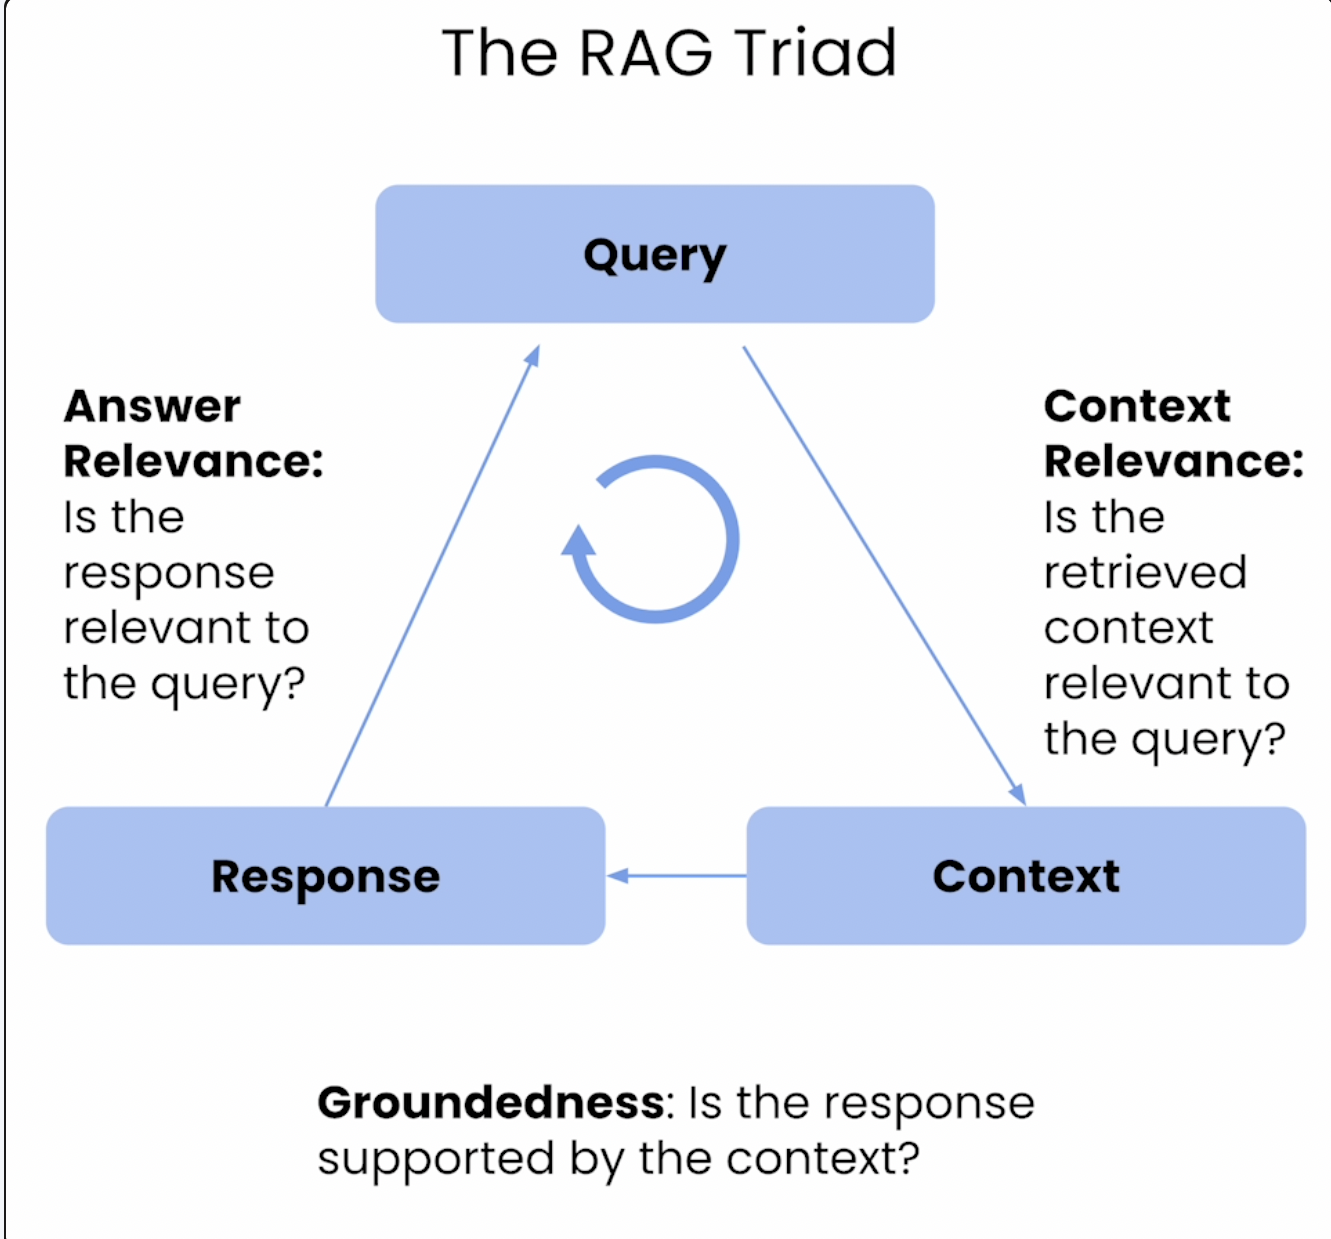

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import utils

import os
import openai
openai.api_key = utils.get_openai_api_key()

In [3]:
from trulens_eval import Tru

tru = Tru()
tru.reset_database()

🦑 Tru initialized with db url sqlite:///default.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of `Tru` to prevent this.


In [4]:
from llama_index import SimpleDirectoryReader

documents = SimpleDirectoryReader(
    input_files=["./eBook-How-to-Build-a-Career-in-AI.pdf"]
).load_data()

In [5]:
from llama_index import Document

document = Document(text="\n\n".\
                    join([doc.text for doc in documents]))

In [6]:
from utils import build_sentence_window_index

from llama_index.llms import OpenAI

llm = OpenAI(model="gpt-3.5-turbo", temperature=0.1)

sentence_index = build_sentence_window_index(
    document,
    llm,
    embed_model="local:BAAI/bge-small-en-v1.5",
    save_dir="sentence_index"
)

[nltk_data] Downloading package punkt to /tmp/llama_index...
[nltk_data]   Unzipping tokenizers/punkt.zip.


config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [7]:
from utils import get_sentence_window_query_engine

sentence_window_engine = \
get_sentence_window_query_engine(sentence_index)

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

In [8]:
output = sentence_window_engine.query(
    "How do you create your AI portfolio?")
output.response

'You create your AI portfolio by showcasing a progression of projects that demonstrate your skills.'

## Feedback functions

In [9]:
import nest_asyncio

nest_asyncio.apply()

In [10]:
from trulens_eval import OpenAI as fOpenAI

provider = fOpenAI()

### 1. Answer Relevance

In [11]:
from trulens_eval import Feedback

f_qa_relevance = Feedback(
    provider.relevance_with_cot_reasons,
    name="Answer Relevance"
).on_input_output()

✅ In Answer Relevance, input prompt will be set to __record__.main_input or `Select.RecordInput` .
✅ In Answer Relevance, input response will be set to __record__.main_output or `Select.RecordOutput` .


### 2. Context Relevance

In [12]:
from trulens_eval import TruLlama

context_selection = TruLlama.select_source_nodes().node.text

In [13]:
import numpy as np

f_qs_relevance = (
    Feedback(provider.qs_relevance,
             name="Context Relevance")
    .on_input()
    .on(context_selection)
    .aggregate(np.mean)
)

✅ In Context Relevance, input question will be set to __record__.main_input or `Select.RecordInput` .
✅ In Context Relevance, input statement will be set to __record__.app.query.rets.source_nodes[:].node.text .


In [14]:
import numpy as np

f_qs_relevance = (
    Feedback(provider.qs_relevance_with_cot_reasons,
             name="Context Relevance")
    .on_input()
    .on(context_selection)
    .aggregate(np.mean)
)

✅ In Context Relevance, input question will be set to __record__.main_input or `Select.RecordInput` .
✅ In Context Relevance, input statement will be set to __record__.app.query.rets.source_nodes[:].node.text .


### 3. Groundedness

In [15]:
from trulens_eval.feedback import Groundedness

grounded = Groundedness(groundedness_provider=provider)

In [16]:
f_groundedness = (
    Feedback(grounded.groundedness_measure_with_cot_reasons,
             name="Groundedness"
            )
    .on(context_selection)
    .on_output()
    .aggregate(grounded.grounded_statements_aggregator)
)

✅ In Groundedness, input source will be set to __record__.app.query.rets.source_nodes[:].node.text .
✅ In Groundedness, input statement will be set to __record__.main_output or `Select.RecordOutput` .


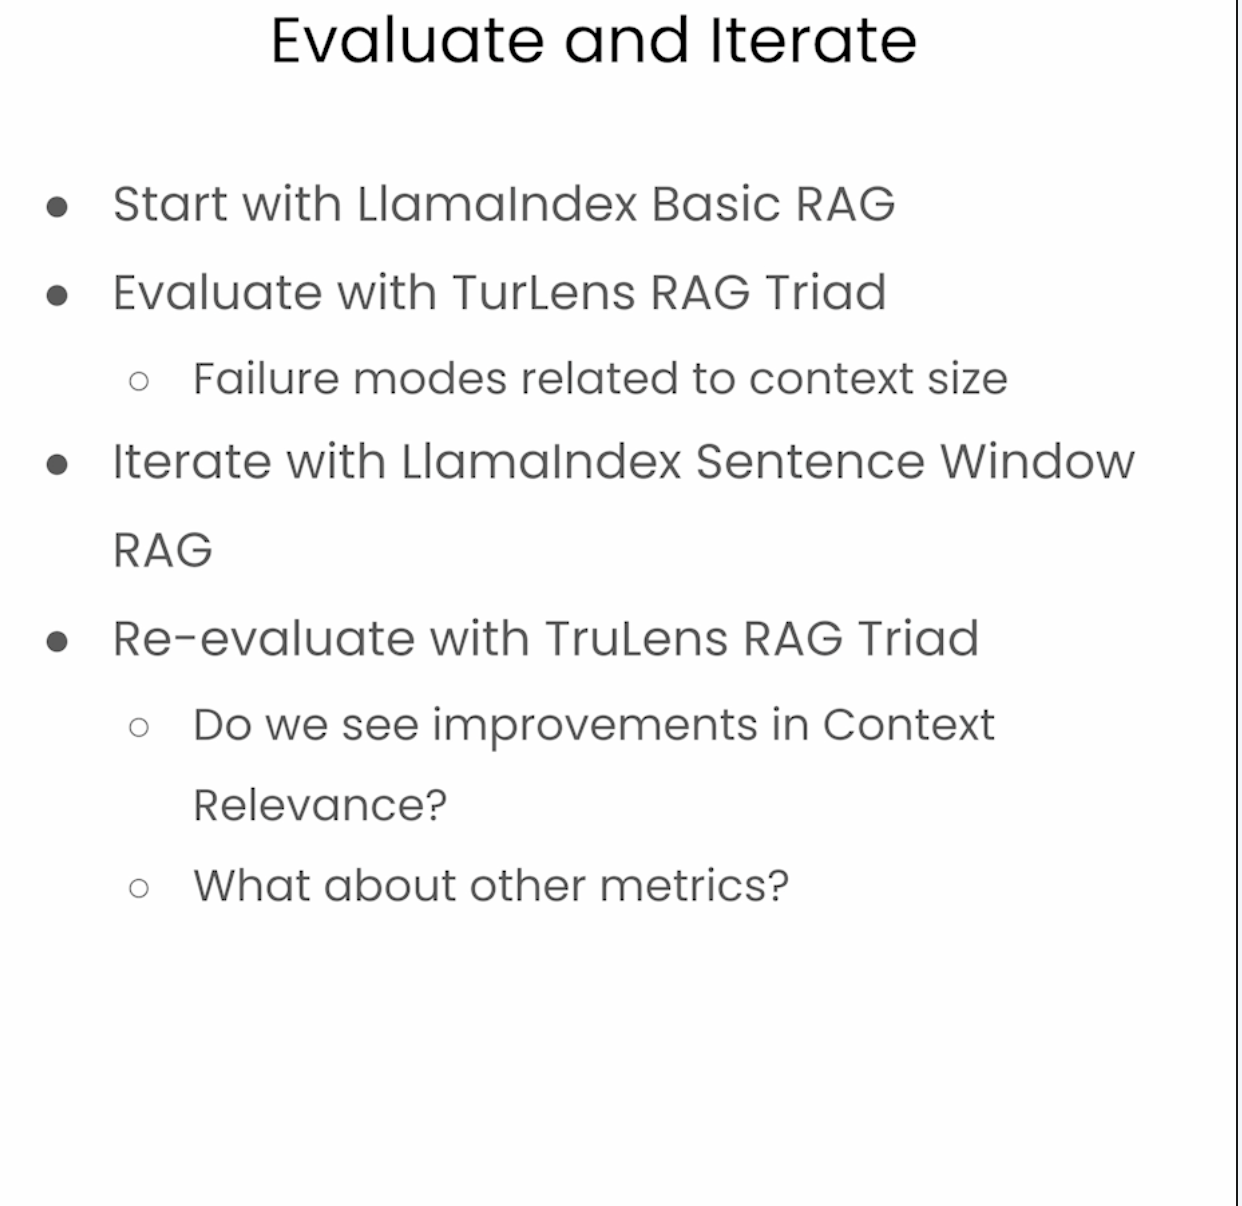

## Evaluation of the RAG application

In [17]:
from trulens_eval import TruLlama
from trulens_eval import FeedbackMode

tru_recorder = TruLlama(
    sentence_window_engine,
    app_id="App_1",
    feedbacks=[
        f_qa_relevance,
        f_qs_relevance,
        f_groundedness
    ]
)

In [18]:
eval_questions = []
with open('eval_questions.txt', 'r') as file:
    for line in file:
        # Remove newline character and convert to integer
        item = line.strip()
        eval_questions.append(item)

In [19]:
eval_questions

['What are the keys to building a career in AI?',
 'How can teamwork contribute to success in AI?',
 'What is the importance of networking in AI?',
 'What are some good habits to develop for a successful career?',
 'How can altruism be beneficial in building a career?',
 'What is imposter syndrome and how does it relate to AI?',
 'Who are some accomplished individuals who have experienced imposter syndrome?',
 'What is the first step to becoming good at AI?',
 'What are some common challenges in AI?',
 'Is it normal to find parts of AI challenging?']

In [20]:
eval_questions.append("How can I be successful in AI?")

In [21]:
eval_questions

['What are the keys to building a career in AI?',
 'How can teamwork contribute to success in AI?',
 'What is the importance of networking in AI?',
 'What are some good habits to develop for a successful career?',
 'How can altruism be beneficial in building a career?',
 'What is imposter syndrome and how does it relate to AI?',
 'Who are some accomplished individuals who have experienced imposter syndrome?',
 'What is the first step to becoming good at AI?',
 'What are some common challenges in AI?',
 'Is it normal to find parts of AI challenging?',
 'How can I be successful in AI?']

In [22]:
for question in eval_questions:
    with tru_recorder as recording:
        sentence_window_engine.query(question)

In [23]:
records, feedback = tru.get_records_and_feedback(app_ids=[])
records.head()

,app_id,app_json,type,record_id,input,output,tags,record_json,cost_json,perf_json,ts,Answer Relevance,Groundedness,Context Relevance,Answer Relevance_calls,Groundedness_calls,Context Relevance_calls,latency,total_tokens,total_cost
0,App_1,"{""app_id"": ""App_1"", ""tags"": ""-"", ""metadata"": {...",RetrieverQueryEngine(llama_index.query_engine....,record_hash_666a0889966eaaa52d3412b7814eaefe,"""What are the keys to building a career in AI?""","""Learning foundational technical skills, worki...",-,"{""record_id"": ""record_hash_666a0889966eaaa52d3...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2025-02-24T22:42:46.454274"", ""...",2025-02-24T22:42:47.940359,1.0,0.500000,0.5,[{'args': {'prompt': 'What are the keys to bui...,[{'args': {'source': 'Chapter 7: A Simple Fram...,[{'args': {'question': 'What are the keys to b...,1,510,0.000780
1,App_1,"{""app_id"": ""App_1"", ""tags"": ""-"", ""metadata"": {...",RetrieverQueryEngine(llama_index.query_engine....,record_hash_90b955b9d54ffa4c65bc82b80a7829f4,"""How can teamwork contribute to success in AI?""","""Teamwork can contribute to success in AI by a...",-,"{""record_id"": ""record_hash_90b955b9d54ffa4c65b...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2025-02-24T22:42:48.090637"", ""...",2025-02-24T22:42:50.283413,1.0,0.666667,NaN,[{'args': {'prompt': 'How can teamwork contrib...,[{'args': {'source': 'To get a project starte...,NaN,2,627,0.000976
2,App_1,"{""app_id"": ""App_1"", ""tags"": ""-"", ""metadata"": {...",RetrieverQueryEngine(llama_index.query_engine....,record_hash_f9acf1b5e04002b634d99350f58e06fe,"""What is the importance of networking in AI?""","""Networking in AI is crucial as it can provide...",-,"{""record_id"": ""record_hash_f9acf1b5e04002b634d...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2025-02-24T22:42:50.553707"", ""...",2025-02-24T22:42:53.147255,1.0,NaN,NaN,[{'args': {'prompt': 'What is the importance o...,NaN,NaN,2,544,0.000871
3,App_1,"{""app_id"": ""App_1"", ""tags"": ""-"", ""metadata"": {...",RetrieverQueryEngine(llama_index.query_engine....,record_hash_3a4a8586c3b177fb334798e586fce376,"""What are some good habits to develop for a su...","""Developing good habits in areas such as eatin...",-,"{""record_id"": ""record_hash_3a4a8586c3b177fb334...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2025-02-24T22:42:53.448032"", ""...",2025-02-24T22:42:55.061707,1.0,NaN,NaN,[{'args': {'prompt': 'What are some good habit...,NaN,NaN,1,456,0.000713
4,App_1,"{""app_id"": ""App_1"", ""tags"": ""-"", ""metadata"": {...",RetrieverQueryEngine(llama_index.query_engine....,record_hash_6e96ddf1650b237f19769c8d2dbca00c,"""How can altruism be beneficial in building a ...","""Helping others along the way can actually ben...",-,"{""record_id"": ""record_hash_6e96ddf1650b237f197...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2025-02-24T22:42:55.190629"", ""...",2025-02-24T22:42:56.365159,1.0,NaN,NaN,[{'args': {'prompt': 'How can altruism be bene...,NaN,NaN,1,477,0.000724


In [24]:
import pandas as pd

pd.set_option("display.max_colwidth", None)
records[["input", "output"] + feedback]

,input,output,Groundedness,Context Relevance,Answer Relevance
0,"""What are the keys to building a career in AI?""","""Learning foundational technical skills, working on projects, finding a job, and being part of a supportive community are the keys to building a career in AI.""",0.500000,0.5,1.0
1,"""How can teamwork contribute to success in AI?""","""Teamwork can contribute to success in AI by allowing individuals to leverage the diverse skills and perspectives of their colleagues. Working collaboratively enables team members to share insights, problem-solve more effectively, and collectively make better decisions. Additionally, being surrounded by motivated and knowledgeable teammates can inspire individuals to continuously learn and improve, ultimately leading to better project outcomes.""",0.666667,NaN,1.0
2,"""What is the importance of networking in AI?""","""Networking in AI is crucial as it can provide valuable insights, guidance, and opportunities for individuals looking to advance in the field. By connecting with professionals who have experience in AI, individuals can gain knowledge about the industry, potential career paths, and current trends. Networking also allows individuals to build relationships with others in the field, which can lead to mentorship, collaboration on projects, and even job opportunities. Additionally, networking helps individuals stay informed about the latest developments in AI and can open doors to new connections and resources that can further their career growth.""",NaN,NaN,1.0
3,"""What are some good habits to develop for a successful career?""","""Developing good habits in areas such as eating, exercise, sleep, personal relationships, work, learning, and self-care can help individuals move forward in their careers while also maintaining their health. Additionally, aiming to lift others during every step of one's own journey can lead to better outcomes.""",NaN,NaN,1.0
4,"""How can altruism be beneficial in building a career?""","""Helping others along the way can actually benefit one's own career development.""",NaN,NaN,1.0
5,"""What is imposter syndrome and how does it relate to AI?""","""Imposter syndrome is a phenomenon where individuals doubt their accomplishments and have a persistent fear of being exposed as a fraud. In the context of AI, newcomers to the field may experience imposter syndrome, feeling like they do not truly belong in the AI community despite their success. This can be a significant challenge for individuals in AI, as it may hinder their growth and progress in the field.""",NaN,NaN,NaN
6,"""Who are some accomplished individuals who have experienced imposter syndrome?""","""Former Facebook COO Sheryl Sandberg, U.S. first lady Michelle Obama, actor Tom Hanks, and Atlassian co-CEO Mike Cannon-Brookes.""",NaN,NaN,NaN
7,"""What is the first step to becoming good at AI?""","""Identifying possible roles and conducting informational interviews.""",NaN,NaN,NaN
8,"""What are some common challenges in AI?""","""Common challenges in AI include the evolving nature of technologies, the need to constantly keep up-to-date with changing technology, the difficulty in estimating project timelines and return on investment, the iterative nature of AI projects leading to uncertainties in project management, the necessity to collaborate with stakeholders lacking expertise in AI, and the challenge of finding suitable AI skills that companies require for hiring.""",NaN,NaN,NaN
9,"""Is it normal to find parts of AI challenging?""","""It is normal to find parts of AI challenging.""",NaN,NaN,NaN


In [25]:
tru.get_leaderboard(app_ids=[])

,Groundedness,Context Relevance,Answer Relevance,latency,total_cost
app_id,,,,,
App_1,0.583333,0.5,1.0,1.454545,0.000842


In [26]:
tru.run_dashboard()

Starting dashboard ...
Config file already exists. Skipping writing process.
Credentials file already exists. Skipping writing process.


Accordion(children=(VBox(children=(VBox(children=(Label(value='STDOUT'), Output())), VBox(children=(Label(valu…

Dashboard started at https://s172-29-34-155p38560.lab-aws-production.deeplearning.ai/ .


<Popen: returncode: None args: ['streamlit', 'run', '--server.headless=True'...>